In [3]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')


Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/450 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [24]:
import pandas as pd

seven = pd.read_csv("data.csv")

In [14]:
data = seven['txt'].tolist()
data

['CODA4582ROG  RF LP FLASHING US -  failed self install. activated coax riser.All good',
 'DSRX POWER , DS SNR OUT OF SPEC, ROLL TO DOOR repair riser',
 'CODA4582ROG INT. MODEM ALREADY SWAPPED. INTERNAL CABLING ISSUE AS PER PRIOR TRUCK. RAN NEW RISR FRM TAP TO CX,PROVIDE NEW SPLITR,EDU TAP-70/21,98/8,134/12,ALL WRKING F9',
 'ASSIST CONTRACTOR WITH REPLACING DROP - POLETO CSE / CX HAS CORRECT DROP CABLE ALREADY. CX CONDUIT THE CABLE/RESCHL CALL WHEN DONE/NBH/COVID 19',
 'CGNM3552 ! AREA OK ! MIBS WITHIN SPEC ! MULTIPLE VISITS ALREADY CX HAVE 2 CGN MDM/NEWER MDM MIBS IN SPECTS/INTRNL ISSUE/EDU CX/C19 NO ACCESS INSIDE',
 'ONGOING ISSUES REFER TO SR CX NOT HOME  AND PHONE NUMBER IS WRONG SOMEONE ELSE UNSWEAR SAID WE DONT CAL ROGERS',
 'CODA4582U/PERSISTENT INTERMITTENT ISSUE/MIBSOUT OF SPEC TRBSHT FRM OTSD/NO ACES TO UNT/COVID-19/EDU CX TO RMV 6DB ATNTR/NT ABLE/MDM WKN FN',
 'CODA4582U/T3TIMEOUTS/NEEDACCESSTOTAP/ASPERLASTTECH/CONNECTEDROWHOUSE LOW SGNL@TAP,REFER MAINT, NEED ACCESS TO INSID

In [11]:
embeddings = model.encode(data, show_progress_bar=True)

Batches:   0%|          | 0/1549 [00:00<?, ?it/s]

In [111]:
embeddings

In [6]:
import umap.umap_ as umap
umap_embeddings = umap.UMAP(n_neighbors=5, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

In [27]:
import numba

numba.__version__

'0.54.1'

In [4]:
# Reload the file
embeddings = pickle.load(open("company1.pickle", "rb"))

In [112]:
embeddings

In [8]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

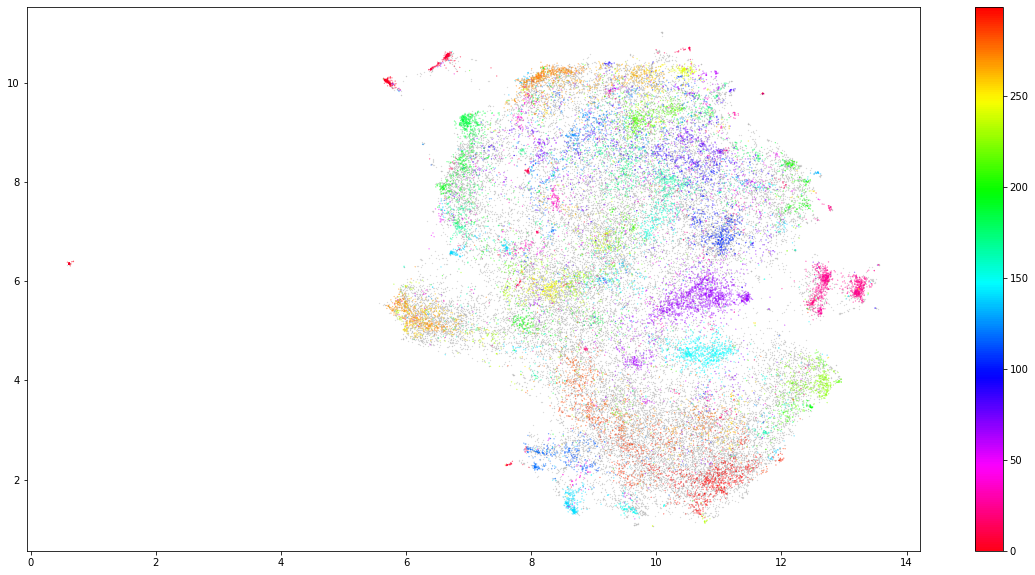

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [15]:
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [16]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

In [17]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

/Applications/anaconda3/envs/NLMLBERT/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Topic,Size
0,-1,32124
67,66,1444
147,146,682
214,213,535
274,273,490
300,299,461
25,24,410
24,23,405
186,185,372
142,141,270


In [109]:
top_n_words[273][:10]

[('max', 0.14458044765997896),
 ('min', 0.1383792078865219),
 ('tx', 0.08691973398470418),
 ('snr', 0.06995558437024631),
 ('rx', 0.06567706488250062),
 ('amp', 0.03047952530497306),
 ('53', 0.029391024008521845),
 ('39', 0.025386536013455963),
 ('ok', 0.024667762227598162),
 ('40', 0.024565791062477218)]

In [110]:
top_n_words[299][:10]

[('internet', 0.08835109066111435),
 ('rf', 0.03336240355096822),
 ('edu', 0.03147940634461914),
 ('cable', 0.028806630108493228),
 ('ok', 0.027020561211339764),
 ('area', 0.02648875562589345),
 ('connection', 0.02637598702926295),
 ('yes', 0.025171927125905633),
 ('amp', 0.02260554249822272),
 ('tap', 0.022381068108434356)]

In [106]:
documents = data_text


In [52]:
stemmer = nltk.stem.porter.PorterStemmer()


In [53]:
doc_sample = documents[documents['index'] == 4310].values[0][0]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['MDM-CGN3ACSMR', 'TX:57.0', 'IS', 'BAD', 'AREA', 'IS', 'OKAY', 'PLS', 'CHECK', 'CONNECTIONS', 'replaced', 'faulty', 'and', 'rusty', 'connections', 'and', 'ground,edu', 'cx', 'on', 'ignite', 'cx', 'to', 'call,no', 'inside#c19']


 tokenized and lemmatized document: 
['acsmr', 'area', 'okay', 'check', 'connect', 'replac', 'faulti', 'rusti', 'connect', 'grind', 'ignit', 'insid']


In [54]:
processed_docs = documents['txt'].map(preprocess)
processed_docs[:10]

0    [coda, flash, fail, self, instal, activ, coax,...
1       [dsrx, power, spec, roll, door, repair, riser]
2    [coda, modem, swap, intern, cabl, issu, prior,...
3    [assist, contractor, replac, drop, poleto, cor...
4    [cgnm, area, mib, spec, multipl, visit, newer,...
5    [ongo, issu, refer, home, phone, number, wrong...
6    [coda, persist, intermitt, issu, mibsout, spec...
7    [coda, timeout, needaccesstotap, asperlasttech...
8    [coda, spec, nois, chanel, area, roll, door, a...
9    [issu, internet, speed, wire, mbp, wifi, mbp, ...
Name: txt, dtype: object

In [55]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 activ
1 coax
2 coda
3 fail
4 flash
5 good
6 instal
7 riser
8 self
9 door
10 dsrx


In [56]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)


In [57]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[4310]

[(31, 1),
 (33, 1),
 (35, 1),
 (64, 1),
 (78, 2),
 (103, 1),
 (110, 1),
 (178, 1),
 (583, 1),
 (689, 1),
 (726, 1)]

In [58]:
bow_doc_4310 = bow_corpus[4310]
for i in range(len(bow_doc_4310)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0], 
                                               dictionary[bow_doc_4310[i][0]], 
bow_doc_4310[i][1]))

Word 31 ("replac") appears 1 time.
Word 33 ("area") appears 1 time.
Word 35 ("insid") appears 1 time.
Word 64 ("check") appears 1 time.
Word 78 ("connect") appears 2 time.
Word 103 ("acsmr") appears 1 time.
Word 110 ("faulti") appears 1 time.
Word 178 ("okay") appears 1 time.
Word 583 ("ignit") appears 1 time.
Word 689 ("grind") appears 1 time.
Word 726 ("rusti") appears 1 time.


In [59]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.42220378210386683),
 (1, 0.3520131085659944),
 (2, 0.20462813299757862),
 (3, 0.3719123364695668),
 (4, 0.3610371903970912),
 (5, 0.2396546713437459),
 (6, 0.3054345296747196),
 (7, 0.2257740352117766),
 (8, 0.4308049415947304)]


In [60]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [61]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.049*"outsid" + 0.041*"good" + 0.039*"area" + 0.039*"signal" + 0.035*"mib" + 0.033*"spec" + 0.028*"offlin" + 0.026*"check" + 0.020*"work" + 0.020*"modem"
Topic: 1 
Words: 0.051*"door" + 0.031*"intermitt" + 0.026*"answer" + 0.024*"roll" + 0.022*"internet" + 0.022*"call" + 0.022*"wrkng" + 0.021*"mib" + 0.018*"time" + 0.018*"modem"
Topic: 2 
Words: 0.121*"modem" + 0.106*"swap" + 0.037*"speed" + 0.032*"faulti" + 0.031*"wifi" + 0.025*"slow" + 0.025*"replac" + 0.019*"offlin" + 0.018*"issu" + 0.017*"need"
Topic: 3 
Words: 0.042*"cabl" + 0.041*"servic" + 0.041*"drop" + 0.037*"remov" + 0.035*"work" + 0.035*"line" + 0.028*"splitter" + 0.019*"connect" + 0.018*"temp" + 0.017*"fine"
Topic: 4 
Words: 0.069*"issu" + 0.053*"drop" + 0.034*"intermitt" + 0.033*"area" + 0.025*"nois" + 0.022*"modem" + 0.018*"refer" + 0.018*"internet" + 0.017*"flap" + 0.016*"offlin"
Topic: 5 
Words: 0.049*"tech" + 0.037*"need" + 0.028*"reloc" + 0.027*"modem" + 0.022*"issu" + 0.018*"insid" + 0.018*"want" + 

In [62]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.016*"speed" + 0.013*"slow" + 0.013*"modem" + 0.011*"issu" + 0.011*"wifi" + 0.010*"amber" + 0.009*"need" + 0.009*"swap" + 0.009*"connect" + 0.009*"flash"
Topic: 1 Word: 0.017*"intermitt" + 0.015*"mib" + 0.015*"spec" + 0.015*"repl" + 0.013*"issu" + 0.013*"riser" + 0.013*"modem" + 0.013*"conn" + 0.012*"swap" + 0.012*"coda"
Topic: 2 Word: 0.014*"area" + 0.012*"mib" + 0.011*"spec" + 0.011*"drop" + 0.011*"issu" + 0.011*"modem" + 0.011*"acsmr" + 0.010*"intermitt" + 0.010*"loss" + 0.009*"remov"
Topic: 3 Word: 0.017*"modem" + 0.015*"drop" + 0.014*"swap" + 0.013*"intermitt" + 0.013*"fido" + 0.012*"reloc" + 0.012*"issu" + 0.011*"connect" + 0.011*"mib" + 0.011*"nois"
Topic: 4 Word: 0.030*"temp" + 0.025*"line" + 0.024*"mlti" + 0.024*"burial" + 0.018*"cabl" + 0.018*"drop" + 0.018*"servic" + 0.017*"offlin" + 0.015*"orang" + 0.014*"repair"
Topic: 5 Word: 0.023*"fhsi" + 0.015*"docsi" + 0.013*"spec" + 0.012*"issu" + 0.012*"servic" + 0.011*"specif" + 0.011*"mib" + 0.011*"intermitt" + 0.0

In [90]:
import spacy
spacy.load('en_core_web_sm')
from spacy.lang.en import English
parser = English()
def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

In [91]:
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

[nltk_data] Downloading package wordnet to /Users/hammad/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [92]:
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hammad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [93]:
def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

In [94]:
import pandas as pd

seven = pd.read_csv("data.csv")
data = seven['txt'].tolist()


In [95]:
import random
text_data = []
for line in data:
    tokens = prepare_text_for_lda(line)
    if random.random() > .99:
        print(tokens)
        text_data.append(tokens)

['coda4582u', 'packet', 'match', 'uptime', 'riser']
['aerial', 'backyard', '150ft', '4p-6;30p', 'working']
['going', 'intermittent', 'issue', 'drop', 'randomly', 'service']
['timeouts', 'devices', 'light', 'modem', 'flash', 'happen']
['coda4582rog', 'provision', 'issue', 'c156633825', 'signal', 'panel']
['intermittent', 'packet', 'replace', 'outside', 'internet', 'working', 'now/#c19']
['model', 'cgn3acsmr', '/internet', 'drop', 'cmtsregister', '/area', 'faulty']
['cgn3acsmr', 'registerd', 'match', 'connection', 'faulty', 'cnctr', 'splittr', 'inside', 'wrking']
['coda4582u', 'intermiittent', 'flapping', 'noise', 'inside', 'posible', 'falty']
['internet', 'intermitten', 'ticket', 'close', 'maint', 'closd', 'investigat', 'signal', 'refer']
['coda4582rog', 'call', 'multiple', 'times', 'issue', 'ticket', 'close', 'buzz:110', 'reset', 'chang', 'connector', 'service']
['tempd', '39/-4']
['customer', 'experience', 'intermittent', 'disconnection', 'model', 'coda4582u', 'buz#9', 'factory', 'res

In [96]:
from gensim import corpora
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]
import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

In [97]:
import gensim
NUM_TOPICS = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.027*"install" + 0.016*"check" + 0.015*"modem" + 0.011*"services"')
(1, '0.028*"intermittent" + 0.026*"issue" + 0.011*"chnge" + 0.009*"repair"')
(2, '0.033*"internet" + 0.022*"cable" + 0.022*"intermittent" + 0.021*"issue"')
(3, '0.054*"modem" + 0.023*"issue" + 0.021*"offline" + 0.018*"riser"')
(4, '0.017*"issue" + 0.012*"intermittent" + 0.012*"cable" + 0.011*"clean"')


In [98]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 3, id2word=dictionary, passes=15)
ldamodel.save('model3.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.026*"intermittent" + 0.022*"issue" + 0.019*"outside" + 0.018*"modem"')
(1, '0.024*"modem" + 0.023*"light" + 0.019*"internet" + 0.016*"issue"')
(2, '0.028*"modem" + 0.019*"offline" + 0.018*"issue" + 0.014*"replace"')


In [99]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 10, id2word=dictionary, passes=15)
ldamodel.save('model10.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.034*"modem" + 0.030*"issue" + 0.021*"internet" + 0.020*"intermittent"')
(1, '0.038*"modem" + 0.027*"outside" + 0.025*"offline" + 0.021*"intermittent"')
(2, '0.018*"rplcd" + 0.014*"aerial" + 0.012*"change" + 0.012*"split"')
(3, '0.035*"intermittent" + 0.031*"internet" + 0.030*"modem" + 0.028*"issue"')
(4, '0.019*"cable" + 0.017*"intermittent" + 0.014*"issue" + 0.014*"check"')
(5, '0.029*"issue" + 0.011*"wrkng" + 0.011*"intermittent" + 0.008*"answer"')
(6, '0.027*"modem" + 0.018*"internet" + 0.017*"cable" + 0.016*"connection"')
(7, '0.027*"modem" + 0.020*"install" + 0.020*"light" + 0.017*"offline"')
(8, '0.026*"modem" + 0.020*"internet" + 0.017*"check" + 0.017*"services"')
(9, '0.044*"issue" + 0.027*"speed" + 0.020*"riser" + 0.018*"modem"')


In [100]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')


In [101]:
import pyLDAvis.gensim_models as gsv

pyLDAvis.enable_notebook()
lda_display = gsv.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/Applications/anaconda3/envs/NLMLBERT/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


/Applications/anaconda3/envs/NLMLBERT/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Applications/anaconda3/envs/NLMLBERT/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Applications/anaconda3/envs/NLMLBERT/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Applications/anaconda3/envs/NLMLBERT/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Applications/anaconda3/envs/NLM